In [1]:
import numpy as np
import splat.simulate as spsim
import numba
import wisps
import matplotlib.pyplot as plt
import bisect 
import emcee
from astropy.coordinates import  SkyCoord 
import astropy.units as u
import scipy.integrate as integrate

%matplotlib inline 

In [176]:

@numba.jit
def convert_to_rz(ra, dec, dist):
    """
    returns r and z given a distance
    """
    newcoord=SkyCoord(ra=ra, dec=dec, distance=dist*u.pc)
    r=(newcoord.cartesian.x**2+newcoord.cartesian.y**2)**0.5
    z=newcoord.cartesian.z
    return r.to(u.pc).value, z.to(u.pc).value

@numba.vectorize
def juric_density_function(r, z):
    
    """
    A custom juric density function that only uses numpy arrays for speed
    All units are in pc
    """
    ##constants
    r0 = 8000 # radial offset from galactic center to Sun
    z0 = 25.  # vertical offset from galactic plane to Sun
    l1 = 2600. # radial length scale of exponential thin disk 
    h1 = 300.# vertical length scale of exponential thin disk 
    ftd = 0.12 # relative number of thick disk to thin disk star counts
    l2 = 3600. # radial length scale of exponential thin disk 
    h2 = 900. # vertical length scale of exponential thin disk 
    fh = 0.0051 # relative number of halo to thin disk star counts
    qh = 0.64 # halo axial ratio
    nh = 2.77 # halo power law index
    
    dens0=1.0
    
    thindens=dens0*np.exp(-abs(r-r0)/l1)*np.exp(-abs(z-z0)/h1)
    thickdens=dens0*np.exp(-abs(r-r0)/l2)*np.exp(-abs(z-z0)/h2)
    halodens= dens0*(((r0/(r**2+(z/qh)**2)**0.5))**nh)
    
    return thindens+ftd*thickdens+fh*halodens


@numba.jit
def custom_volume_correction(c, dmin, dmax, nsamp=100):
    """
    A volume correction term that only uses numpy array for speed
    All units are in pc
    """
    dds = np.linspace(dmin,dmax,nsamp)
    r, z=convert_to_rz(c.ra, c.dec, dds)
    rho=juric_density_function(r, z)
    return integrate.trapz(rho*(dds**2), x=dds)/(dmax**3)

In [186]:
class Pointing(object):
    ## a pointing object making it easier to draw samples
    
    def __init__(self, **kwargs):
        #only input is the direction
        self.coord=kwargs.get('coord', None)
        self.ensemble_samplers=[]
        self._samples=None

    def cdf(self,  dmin, dmax):
        """
        The cumulative distribution function along the line of sight
        """
        @numba.vectorize("float64(float64)")
        def get_cdf_point(x):
            ##get the value of the cdf at a given distance
            return (x**3-dmin**3)*custom_volume_correction(self.coord, dmin,x)
        
        norm=6*(dmax**3)*custom_volume_correction(self.coord, dmin, 2*dmax)
        dds=np.linspace(dmin+1.0, dmax, 200)
        cdf=get_cdf_point(dds)
        return dds, cdf/norm
    

    def random_draw(self,  dmin, dmax, nsample=1000):
        """
        randomly drawing x distances in a given direction
        """
        dvals, cdfvals=self.cdf(dmax, dmin)
        @numba.vectorize("int32(float64)")
        def invert_cdf(i):
            return bisect.bisect(cdfvals, i)-1
        x=np.random.rand(nsample)
        idx=invert_cdf(x)
        return np.array(dvals)[idx]

    @property
    def samples(self):
        return self._samples
    
    def create_sample(self, dmin, dmax):
        self._samples=self.random_draw(dmax, dmin, nsample=10000)

In [187]:
coord=SkyCoord(ra=45*u.deg, dec=-32*u.deg)

In [188]:
pnt=Pointing(coord=coord)

In [190]:
dmin=201.0
dmax=2000.0
dds, cdf=pnt.cdf(10, 2000)

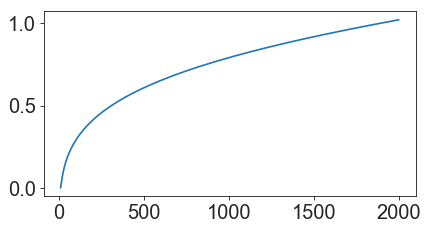

In [191]:
plt.plot(dds, cdf)

In [193]:
pnt.create_sample( dmin, dmax)

(array([1784., 1535., 1145.,  954.,  824.,  663.,  672.,  587.,  515.,
        1321.]),
 array([ 202. ,  381.8,  561.6,  741.4,  921.2, 1101. , 1280.8, 1460.6,
        1640.4, 1820.2, 2000. ]),
 <a list of 10 Patch objects>)

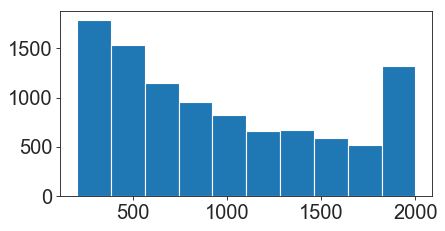

In [195]:
plt.hist(pnt.samples)

In [183]:
%prun pnt.random_draw( dmax, dmin, nsample=10000)

         466387 function calls (454536 primitive calls) in 0.601 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1108    0.078    0.000    0.080    0.000 ffi.py:105(__call__)
        1    0.026    0.026    0.601    0.601 <ipython-input-175-f6425dbbf72e>:24(random_draw)
     2211    0.014    0.000    0.014    0.000 {method 'reduce' of 'numpy.ufunc' objects}
    45338    0.012    0.000    0.014    0.000 {built-in method builtins.isinstance}
     2010    0.011    0.000    0.096    0.000 baseframe.py:983(represent_as)
19739/16724    0.011    0.000    0.035    0.000 {built-in method builtins.getattr}
     3819    0.009    0.000    0.018    0.000 core.py:533(_get_physical_type_id)
     6234    0.009    0.000    0.033    0.000 {built-in method numpy.core.multiarray.array}
      201    0.009    0.000    0.319    0.002 <ipython-input-176-78b824c4bd9d>:2(convert_to_rz)
      201    0.007    0.000    0.368    0.002 <ipython-input